In [17]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import torch
import torchvision.transforms as transforms
import os
import sys
project_root = os.path.abspath(os.path.join('..'))
if project_root not in sys.path:
    sys.path.append(project_root)
from src.models.SRCNN import SRCNN

In [18]:
lr_path = "../data/processed/DIV2K/DIV2K_train_LR_x2/0012.png"
hr_path = "../data/raw/DIV2K/DIV2K_train_HR/0012.png"

In [19]:
lr = Image.open(lr_path)
hr = Image.open(hr_path)

In [20]:
lr_up = lr.resize(hr.size, resample=Image.BICUBIC)

In [21]:
model_path = "../models/srcnn_baseline.pth"
model = SRCNN()
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()

SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

In [22]:
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

lr_up_tensor = to_tensor(lr_up).unsqueeze(0)

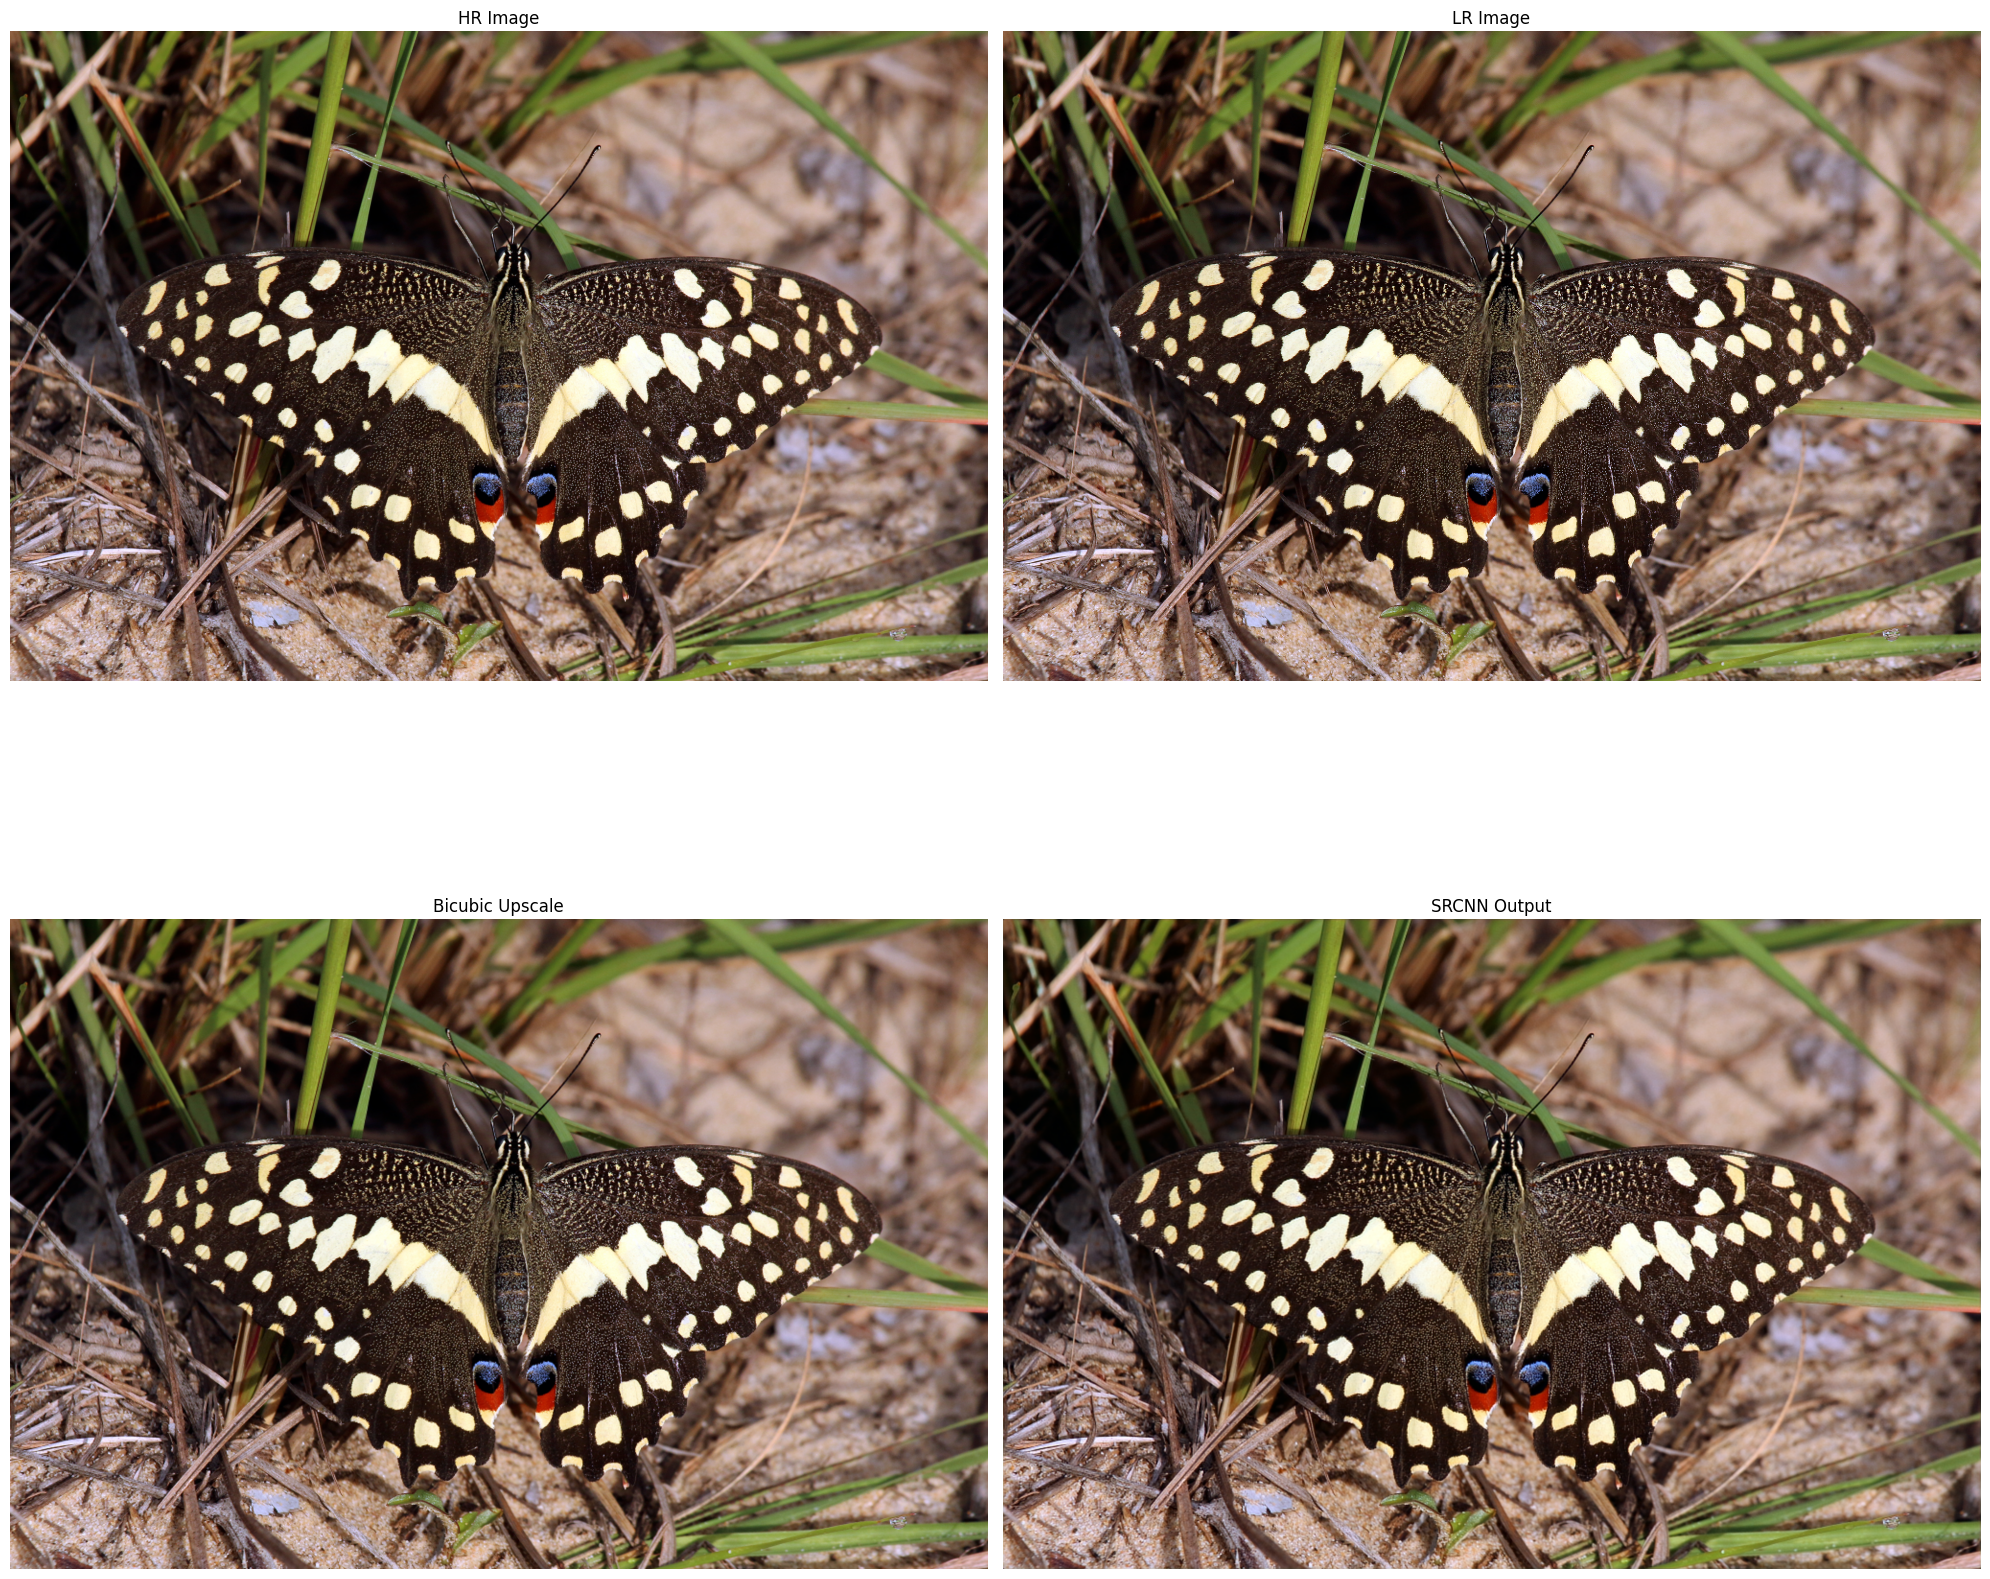

In [23]:
with torch.no_grad():
    sr_tensor = model(lr_up_tensor)
    sr_tensor = sr_tensor.clamp(0.0, 1.0)
    
sr_img = to_pil(sr_tensor.squeeze(0))

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

axes[0][0].imshow(hr)
axes[0][0].set_title('HR Image')
axes[0][0].axis('off')

axes[0][1].imshow(lr)
axes[0][1].set_title('LR Image')
axes[0][1].axis('off')

axes[1][0].imshow(lr_up)
axes[1][0].set_title('Bicubic Upscale')
axes[1][0].axis('off')

axes[1][1].imshow(sr_img)
axes[1][1].set_title('SRCNN Output')
axes[1][1].axis('off')

plt.tight_layout()
plt.show()

In [24]:
psnr_bicubic = psnr(np.array(hr), np.array(lr_up))
psnr_srcnn = psnr(np.array(hr), np.array(sr_img))

print(f"PSNR bicubic: {psnr_bicubic:.2f}")
print(f"PSNR SRCNN: {psnr_srcnn:.2f}")

ssim_bicubic = ssim(np.array(hr), np.array(lr_up), channel_axis=2)
ssim_srcnn = ssim(np.array(hr), np.array(sr_img), channel_axis=2)

print(f"SSIM bicubic: {ssim_bicubic:.2f}")
print(f"SSIM SRCNN: {ssim_srcnn:.2f}")

PSNR bicubic: 29.70
PSNR SRCNN: 28.82
SSIM bicubic: 0.95
SSIM SRCNN: 0.93
